In [1]:
from langchain import OpenAI
from langchain.agents import AgentType, initialize_agent
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import requests
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys
import dziner


from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-ada-002' 

from langchain.text_splitter import CharacterTextSplitter


In [2]:
from dziner.surrogates.CMC.model import predict_single_point

In [3]:
## This model based on this paper: https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
## And is coming from this URL 
## https://github.com/zavalab/ML/blob/master/CMC_GCN/saved_models/gnn_logs_save_202_hu256_lr0.005_best_trainalles_seed4592/ep200bs5lr0.005hu256es.pth.tar

import torch

@tool
def predict_cmc(smiles):
    '''
    This tool predicts the log Critical Micelle Concentration (CMC) for a SMILES. The model is based on a GCN from this paper:
    https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
    '''
    model_path = r"../dziner/surrogates/CMC/ep200bs5lr0.005hu256es.pth.tar"  # Path to the model checkpoint
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    try:
        infered_cmc = predict_single_point(smiles, model_path, device)
    except:
        infered_cmc = None
    return np.round(infered_cmc,3)

predict_cmc('CCCCCOCCO')

3.716

In [4]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making the surfactant with a Critical Micelle Concentration? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize your answer and cite paper
    by the title, DOI and the journal and year the document was published on."""

@tool
def lookup_papers(prompt):
    '''Useful for getting chemical intuition for the problem.
    This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.
    It also includes information on the paper citation or DOI.
    '''
    guide_lines = []
    for m in range(2):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/CMC/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = dziner.RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return " ".join(guide_lines)

# guidel_lines = lookup_papers("")
# guidel_lines

In [5]:

@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid", SMILES

tools = [lookup_papers, check_validity, predict_cmc]

tool_names = [tool.name for tool in tools]  
tool_desc = [tool.description for tool in tools]

initial_surfactant = "CCCCCOCCO" 
Human_prompt = f"Make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC)"

input_data = {
            "input": Human_prompt,
            "prompt": RetrievalQA_prompt,
            "tools": tools,
            "tool_names": tool_names,
            "tool_desc": tool_desc
        }

In [6]:
from dziner.agents import dZiner
agent = dZiner(tools, property="Critical Micelle Concentration (CMC)",
               model='gpt-4o-2024-05-13', verbose=True).agent

agent.get_prompts

<bound method Runnable.get_prompts of AgentExecutor(memory=ConversationBufferMemory(output_key='output', input_key='input', return_messages=True, memory_key='chat_history'), verbose=True, tags=['zero-shot-react-description'], agent=ZeroShotAgent(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_desc', 'tool_names'], template='You are a helpful Chemist AI assistant called dZiner. You are tasked to make changes to a molecule based on some design guidelines\n    and optimize the molecule\'s property.\n    Always use the tools to get chemical intuition learn about the design guidelines. If you don\'t know, do not make up answers.\n    Explain changes you make in details at each step but do not put redundant information.\n    \n    RESPONSE FORMAT INSTRUCTIONS\n    ----------------------------\n    \n    When responding, please output a response in Slack markdown format only:\n    \n    Markdown code snippet formatted in the following schema:\n    

In [7]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [8]:
initial_surfactant = "CCCCCOCCO" 
# question = f"Look up design guidelines and make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC):\
#             Alway evaluate the CMC and then validity of the input SMILES first\
#              After each change you should calculate the logCMC predicted value and evaluate the the validity of the new molecule. \
#             if invalid revert change to the previous valid SMILES and try something else and re-evauate validity.\
#             Do not make changes involving Fluorine.\
#              Iterate for 10 new molecule candidates and then stop.\n\
#              "
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter(input_data):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_cmc":
                infered_cmc = value
            if action.tool == "check_validity":
                chemical_feasibility, SMILES = value
                iteration_data.append({
                                        'iteration': iteration,
                                        'data': {
                                            'SMILES': SMILES,
                                            'Chemical Feasibility': chemical_feasibility,
                                            'CMC': infered_cmc,
                                        }
                                    })
                iteration += 1
                # break 
                # assert is_prime(int(value))
            # Ask user if they want to continue
            # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
            # if _continue.lower() != "y":
            #     break
    cost += cb.total_cost

print(f'Cost: ${cost}')



> Entering new AgentExecutor chain...
To make changes to the molecule CCCCCOCCO (hexyl ethylene glycol ether) to lower its Critical Micelle Concentration (CMC), I need to first evaluate its current CMC and check its validity. Then, I will look up design guidelines for lowering CMC and make appropriate changes.

Let's start by predicting the CMC and checking the validity of the initial molecule.

Action: predict_cmc
Action Input: CCCCCOCCO


Observation: 3.716
Thought:The predicted log CMC for the molecule CCCCCOCCO is 3.716. Now, let's check the validity of this molecule.

Action: check_validity
Action Input: CCCCCOCCO

Observation: ('Valid', 'CCCCCOCCO\n')
Thought:The initial molecule CCCCCOCCO is valid. Now, let's look up design guidelines for lowering the Critical Micelle Concentration (CMC).

Action: lookup_papers
Action Input: design guidelines for lowering Critical Micelle Concentration (CMC)

Observation: To design a surfactant with a specific Critical Micelle Concentration (C

In [10]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.716}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.552}},
 {'iteration': 2,
  'data': {'SMILES': 'CCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.497}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.173}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 2.746}},
 {'iteration': 5,
  'data': {'SMILES': 'CCCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.999}},
 {'iteration': 6,
  'data': {'SMILES': 'CCCCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.198}},
 {'iteration': 7,
  'data': {'SMILES': 'CCCCCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 0.861}},
 {'iteration': 8,
  'data': {'SMILES': 'CCCCCCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   '

In [11]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/CMC/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

Text(0, 0.5, 'logCMC (μM)')

<Figure size 2560x1920 with 0 Axes>

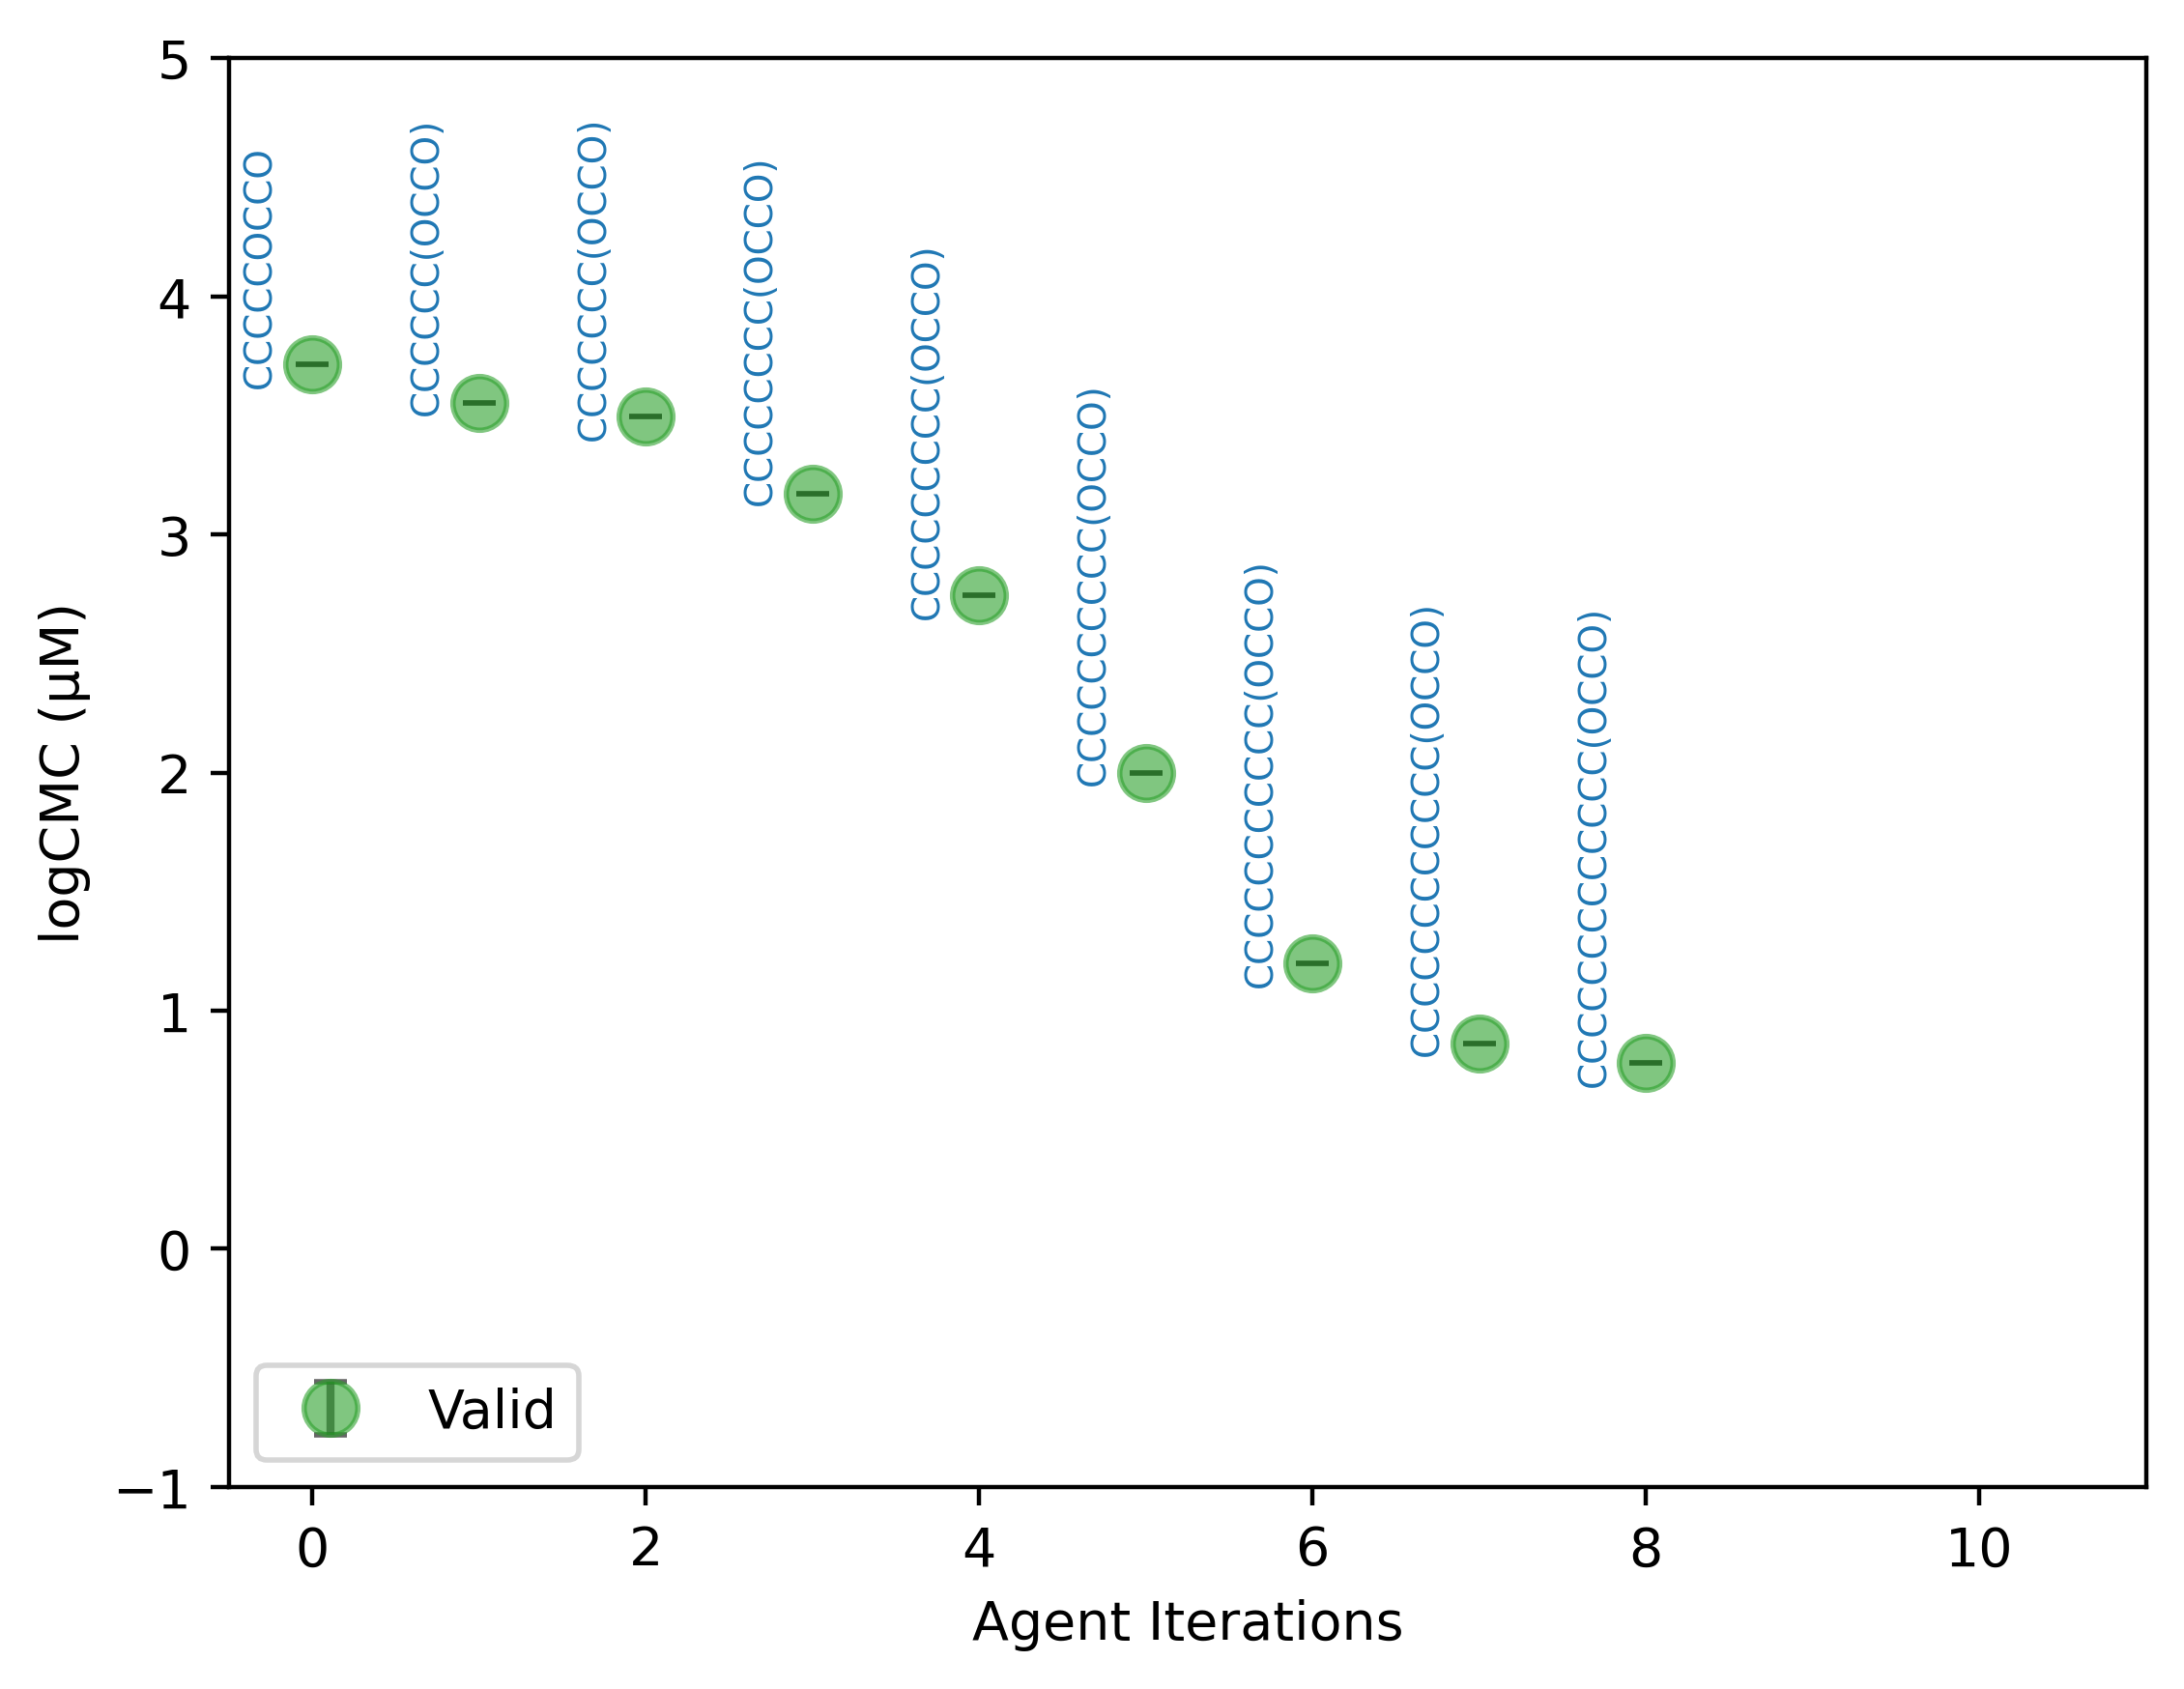

In [12]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
# std_band_gaps = [item['data']['STD CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_cmcs, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

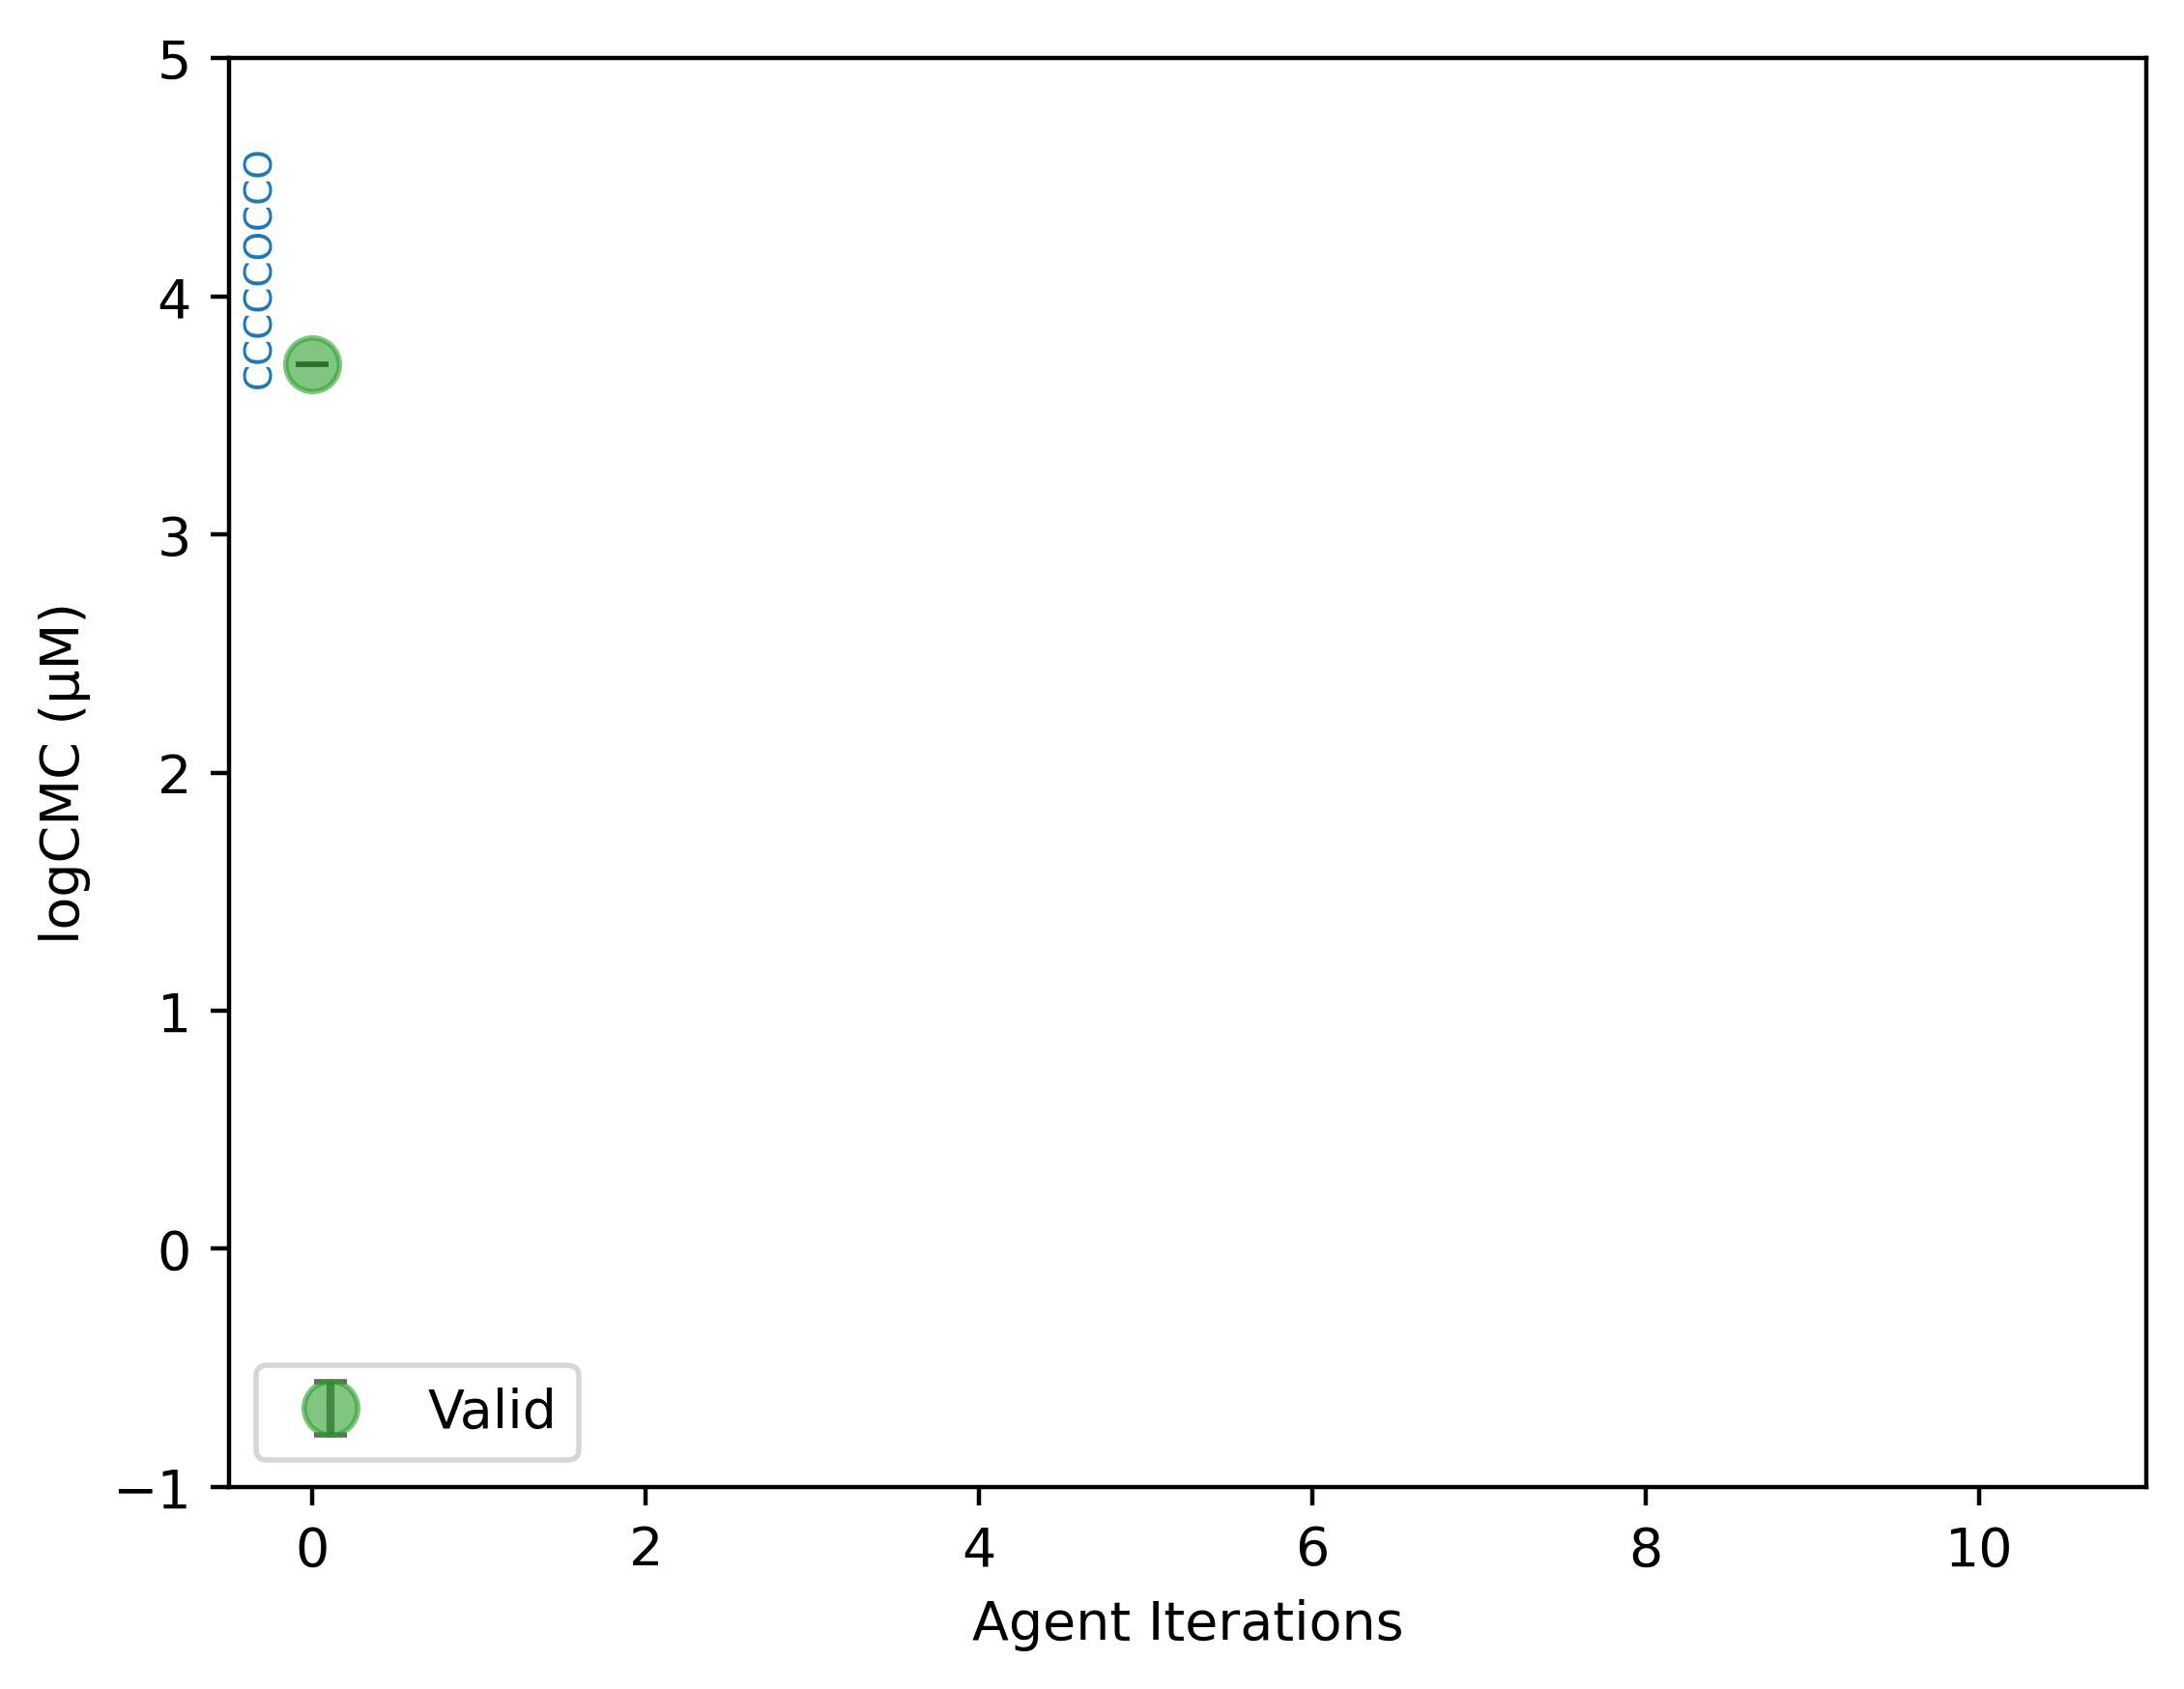

In [13]:
## Plotting sequntially for presentation purposes

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")


import json


with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
    iteration_data = json.load(json_file)

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
std_cmcs = np.zeros(len(mean_cmcs))
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points

iter = 0

plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

    filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
    visualize_smiles(smiles_labels[i], filename)
    if i == iter:
        break


vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
    if i == iter:
        break

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")

# Example usage
filename = f'{initial_surfactant}.png'
visualize_smiles(initial_surfactant, filename)

In [15]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")